# Entrega laboratorio 7
## Integrantes 

- Javier Barrera - 202214779
- Julian Santiago Rolon Toloza - 202215839

In [1]:
from matplotlib import pyplot as plt
from typing import List, Tuple, NewType
import numpy as np
import pandas as pd
import sympy as sp
import random
import math
import copy
import tabulate
from matplotlib.colors import ListedColormap

np.seterr(divide='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

# Fase 1: Modelado de llegadas y salidas

## Extracción de tasas de llegada

## Modelado de comportamiento por tipo de usuario

In [2]:
import pandas as pd

df_feb = pd.read_excel('SD Feb-May 2019.xlsx', sheet_name='Feb-Mar', parse_dates=['fecha_completa'])
df_abr = pd.read_excel('SD Feb-May 2019.xlsx', sheet_name='Abr-May', parse_dates=['fecha_completa'])
df = pd.concat([df_feb, df_abr], ignore_index=True)


In [3]:
df = df[df['MODO_ACCESO'] == 'Peatonal']
df = df[df['RESULTADO_EVENTO'].str.contains('Granted', na=False)]
df['is_arrival'] = (df['TIPO_ACCESO'].str.strip() == 'IN')
df.set_index('fecha_completa', inplace=True)


In [4]:
df['ROL_norm'] = df['ROL'].str.strip().str.upper()

mapeo = {
    'ESTUDIANTE': 'ESTUDIANTE',
    'ESTUDIANTE': 'ESTUDIANTE',   
    'EMPLEADO':    'ADMINISTRATIVO',

}

df['ROL_modelo'] = df['ROL_norm'].map(mapeo)

print(df['ROL_modelo'].value_counts())


ROL_modelo
ESTUDIANTE        934066
ADMINISTRATIVO    133695
Name: count, dtype: int64


In [5]:
# Conteo de llegadas por intervalo
arrivals = df[df['is_arrival']].resample('15T').size().rename('n_arrivals')
# Conteo de salidas por intervalo
departures = df[~df['is_arrival']].resample('15T').size().rename('n_departures')
lambda_arr = arrivals / 900
lambda_dep = departures / 900


C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4214068662.py:2: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  arrivals = df[df['is_arrival']].resample('15T').size().rename('n_arrivals')
C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4214068662.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  departures = df[~df['is_arrival']].resample('15T').size().rename('n_departures')


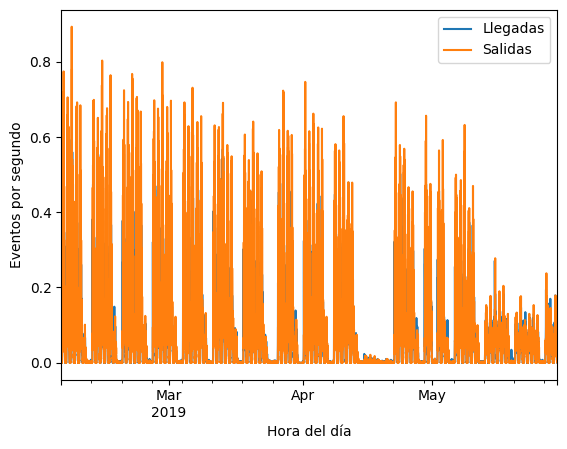

In [6]:
import matplotlib.pyplot as plt

plt.figure()
lambda_arr.plot(label='Llegadas')
lambda_dep.plot(label='Salidas')
plt.ylabel('Eventos por segundo')
plt.xlabel('Hora del día')
plt.legend()
plt.show()


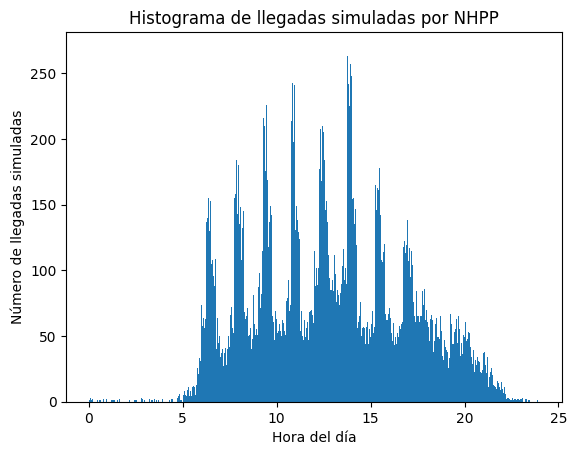

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def simular_nhpp_piecewise(lambda_series, intervalo_seg=900):
    eventos = []
    for t_inicio, tasa in lambda_series.items():
        n = np.random.poisson(tasa * intervalo_seg)

        desplazamientos = np.random.rand(n) * intervalo_seg
        tiempos = t_inicio + pd.to_timedelta(desplazamientos, unit='s')
        eventos.extend(tiempos)
    return sorted(eventos)


llegadas_sim = simular_nhpp_piecewise(lambda_arr)

llegadas_dt = pd.to_datetime(llegadas_sim)
horas = llegadas_dt.hour + llegadas_dt.minute / 60 + llegadas_dt.second / 3600

plt.figure()
plt.hist(horas, bins=len(lambda_arr))
plt.xlabel('Hora del día')
plt.ylabel('Número de llegadas simuladas')
plt.title('Histograma de llegadas simuladas por NHPP')
plt.show()


C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\1850173507.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')
C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\1850173507.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .resample('15T')


<Figure size 1000x600 with 0 Axes>

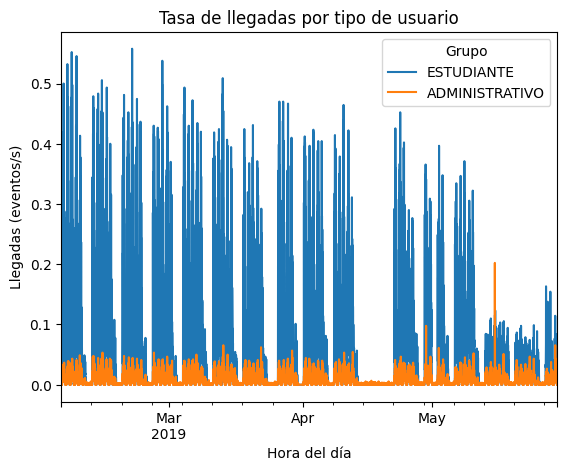

In [8]:


intervalos = lambda_arr.index

tasas_por_grupo = {}
for grupo in ['ESTUDIANTE', 'ADMINISTRATIVO']: 
    serie = (
        df[(df['ROL_modelo']==grupo) & df['is_arrival']]
          .resample('15T')
          .size()
          .div(900)           
          .reindex(intervalos, fill_value=0)
          .rename(grupo)
    )
    tasas_por_grupo[grupo] = serie

import pandas as pd
import matplotlib.pyplot as plt

df_tasas = pd.concat(tasas_por_grupo, axis=1)
plt.figure(figsize=(10,6))
df_tasas.plot()
plt.xlabel('Hora del día')
plt.ylabel('Llegadas (eventos/s)')
plt.title('Tasa de llegadas por tipo de usuario')
plt.legend(title='Grupo')
plt.show()



# Fase 2: Implementación de la simulación en SimPy
## Definir las clases y los recursos
## Implementación de procesos
## Recopilación de estadísticas

In [9]:

df.columns = (
    df.columns
      .str.strip()                            
      .str.lower()                            
      .str.replace(r'\s+', '_', regex=True)   
)

print(df.columns.tolist())


['mes', 'dia', 'modo_acceso', 'porteria', 'resultado_evento', 'rol', 'tipo_acceso', 'is_arrival', 'rol_norm', 'rol_modelo']


In [10]:
print(df.index.min(), df.index.max())
print(df.head(3))


2019-02-04 00:53:19 2019-05-29 23:30:31
                         mes  dia modo_acceso  \
fecha_completa                                  
2019-02-04 00:53:19  Febrero    4    Peatonal   
2019-02-04 00:55:43  Febrero    4    Peatonal   
2019-02-04 00:56:17  Febrero    4    Peatonal   

                                             porteria  \
fecha_completa                                          
2019-02-04 00:53:19  SD                                 
2019-02-04 00:55:43  SD                                 
2019-02-04 00:56:17  SD                                 

                                       resultado_evento  \
fecha_completa                                            
2019-02-04 00:53:19  Access Grant: Access Granted Local   
2019-02-04 00:55:43  Access Grant: Access Granted Local   
2019-02-04 00:56:17  Access Grant: Access Granted Local   

                                                                   rol  \
fecha_completa                                            

In [11]:
df['modo_norm'] = df['modo_acceso'].str.strip().str.title()
df = df[df['modo_norm'] == 'Peatonal']
df = df[df['resultado_evento'].str.contains('Granted', na=False)]
df['is_arrival'] = df['tipo_acceso'].str.strip().str.upper() == 'IN'
print(df.index.min(), df.index.max())



2019-02-04 00:53:19 2019-05-29 23:30:31


C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4234125873.py:19: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  dt_s = pd.Timedelta(interval).seconds
C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4234125873.py:22: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['slot'] = df.index.floor(interval).time


Espera media: 456233.94 s
Percentil 95: 866600.34 s


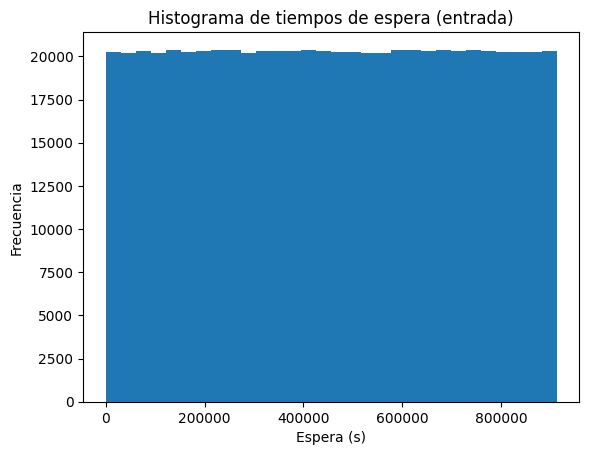

In [16]:
import pandas as pd
import numpy as np
import simpy
import matplotlib.pyplot as plt


df.columns = df.columns.str.strip().str.lower().str.replace(r'\s+', '_', regex=True)


df['datetime'] = pd.to_datetime(df['dia'], dayfirst=True, errors='coerce')
df.set_index('datetime', inplace=True)

df = df[df['modo_acceso'].str.strip().str.title() == 'Peatonal']
df = df[df['resultado_evento'].str.contains('Granted', na=False)]
df['is_arrival'] = df['tipo_acceso'].str.strip().str.upper() == 'IN'


interval = '15T'
dt_s = pd.Timedelta(interval).seconds


df['slot'] = df.index.floor(interval).time


cnt = df[df['is_arrival']].groupby('slot').size()
n_days = df.index.normalize().nunique()


lambda_slot = (cnt / n_days) / dt_s

base = pd.to_datetime([str(t) for t in lambda_slot.index])
lambda_arr = pd.Series(lambda_slot.values, index=base)

def sim_nhpp(lambda_s, delta_s):
    evs = []
    for t0, rate in lambda_s.items():
        k = np.random.poisson(rate * delta_s)
        offs = np.random.random(k) * delta_s
        ts = t0 + pd.to_timedelta(offs, unit='s')
        evs.extend(ts)
    return sorted(evs)

arrivals_day = sim_nhpp(lambda_arr, dt_s)

t0 = arrivals_day[0]
rel = [(t - t0).total_seconds() for t in arrivals_day]
inter_lleg = [rel[0]] + [rel[i] - rel[i-1] for i in range(1, len(rel))]

CAP = 2
T_CARNET = 5
T_PASAR  = 3
SIGMA    = 1.0

env = simpy.Environment()
rec = simpy.Resource(env, capacity=CAP)
stats = []

def persona(env, pid, recurso):

    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))

    t0 = env.now
    with recurso.request() as req:
        yield req
        stats.append(env.now - t0)    
        yield env.timeout(max(0, np.random.normal(T_PASAR, SIGMA)))

def gen(env, inters, recurso, mode):
    pid = 0
    for dt in inters:
        dt = max(0, dt)
        yield env.timeout(dt)
        env.process(persona(env, pid, recurso))
        pid += 1


env.process(gen(env, inter_lleg, rec, mode='arrival'))
env.run()

print(f"Espera media: {np.mean(stats):.2f} s")
print(f"Percentil 95: {np.percentile(stats, 95):.2f} s")

plt.hist(stats, bins=30)
plt.xlabel('Espera (s)')
plt.ylabel('Frecuencia')
plt.title('Histograma de tiempos de espera (entrada)')
plt.show()


### Salidas 

In [ ]:
salidas_day = sim_nhpp(lambda_dep, dt_s)

t0      = arrivals_day[0]
sal_rel = sorted([(t - t0).total_seconds() for t in salidas_day])
inter_sal = [max(0, sal_rel[0])] + [
    max(0, sal_rel[i] - sal_rel[i-1]) for i in range(1, len(sal_rel))
]

import simpy
import numpy as np

env_exit   = simpy.Environment()
rec_exit   = simpy.Resource(env_exit, capacity=CAP)
stats_exit = []

def persona_exit(env, pid, recurso):
    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))
    with recurso.request() as req:
        t_esp = env.now
        yield req

        stats_exit.append(env.now - t_esp)

        yield env.timeout(max(0, np.random.normal(T_PASAR, SIGMA)))

def gen_exit(env, inters, recurso):
    pid = 0
    for dt in inters:
        yield env.timeout(dt)
        env.process(persona_exit(env, pid, recurso))
        pid += 1

env_exit.process(gen_exit(env_exit, inter_sal, rec_exit))
env_exit.run()

import numpy as np

if stats_exit:
    print(f"Espera media (exit): {np.mean(stats_exit):.2f} s")
    print(f"Percentil 95 (exit): {np.percentile(stats_exit, 95):.2f} s")
else:
    print("⚠️ No se generaron eventos de salida.")


Espera media (exit): 2.83 s
Percentil 95 (exit): 12.93 s


### Utilizacion de cada torniquete

In [ ]:
stats = {
    'uso_entry': [],
    'uso_exit': [],
    'esperas_entry': [],
    'cola_entry': [],
    'esperas_exit': [],
    'cola_exit': []
}


def persona(env, pid, recursos, mode):
    yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))

    if mode == 'arrival':
        key    = 'entry'
    else:
        key    = 'exit'
    d_serv = max(0, np.random.normal(T_PASAR, SIGMA))

    with recursos[key].request() as req:
        t_esp = env.now
        yield req

        if key == 'entry':
            stats['esperas_entry'].append(env.now - t_esp)
            stats['uso_entry'].append(d_serv)
        else:
            stats['esperas_exit'].append(env.now - t_esp)
            stats['uso_exit'].append(d_serv)


        yield env.timeout(d_serv)
        stats[f'cola_{key}'].append(len(recursos[key].queue))

def gen_2(env, inters, recursos, mode):
    pid = 0
    for dt in inters:
        yield env.timeout(dt)
        env.process(persona(env, pid, recursos, mode))
        pid += 1

env = simpy.Environment()
recursos = {
    'entry': simpy.Resource(env, capacity=2), 
    'exit':  simpy.Resource(env, capacity=2)    
}

env.process(gen_2(env, inter_sal, recursos, mode='departure'))

env.process(gen_2(env, inter_lleg, recursos, mode='arrival'))
env.process(gen_2(env, inter_sal,  recursos, mode='departure'))
env.run()


T_sim       = env.now
util_entry  = sum(stats['uso_entry']) / (2 * T_sim)
util_exit   = sum(stats['uso_exit'])  / (2  * T_sim)

print(f"Utilización Entry: {util_entry:.2%}")
print(f"Utilización Exit:  {util_exit: .2%}")


Utilización Entry: 9.19%
Utilización Exit:   17.60%


# Fase 3: Validación y verificación


In [ ]:
import pandas as pd
import numpy as np

slots = df.index.floor('15T').time

unique_slots = np.unique(slots)

df_feb = pd.read_excel(
    'SD Feb-May 2019.xlsx',
    sheet_name='Feb-Mar',
    parse_dates=['fecha_completa']   
)
df_abr = pd.read_excel(
    'SD Feb-May 2019.xlsx',
    sheet_name='Abr-May',
    parse_dates=['fecha_completa']
)

df = pd.concat([df_feb, df_abr], ignore_index=True)

df['fecha_completa'] = pd.to_datetime(
    df['fecha_completa'],
    dayfirst=True,
    errors='coerce'
)

df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r'\s+', '_', regex=True)
)

df.set_index('fecha_completa', inplace=True)

print("dtype de índice:", df.index.dtype)
print("Primeros 5 timestamps:", df.index[:5])
print(f"Tienes {len(unique_slots)} slots distintos:")
print(unique_slots[:5], "…", unique_slots[-5:])



C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\2856507626.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  slots = df.index.floor('15T').time


dtype de índice: datetime64[ns]
Primeros 5 timestamps: DatetimeIndex(['2019-02-04 00:53:19', '2019-02-04 00:55:43',
               '2019-02-04 00:56:17', '2019-02-04 01:16:01',
               '2019-02-04 01:29:41'],
              dtype='datetime64[ns]', name='fecha_completa', freq=None)
Tienes 96 slots distintos:
[datetime.time(0, 0) datetime.time(0, 15) datetime.time(0, 30)
 datetime.time(0, 45) datetime.time(1, 0)] … [datetime.time(22, 45) datetime.time(23, 0) datetime.time(23, 15)
 datetime.time(23, 30) datetime.time(23, 45)]


In [ ]:
import numpy as np
import pandas as pd

n_days = df.index.normalize().nunique()

slots_all = (df.index.hour * 60 + df.index.minute) // 15

mask_arrivals = df['is_arrival']
slots_arr = slots_all[mask_arrivals]

real_counts = slots_arr.value_counts().sort_index()
real_slot = real_counts.div(n_days) \
                       .reindex(range(96), fill_value=0) \
                       .sort_index()

slots_sim = [(ts.hour*60 + ts.minute) // 15 for ts in arrivals_day]
sim_counts = pd.Series(slots_sim).value_counts().sort_index()
sim_slot = sim_counts.reindex(range(96), fill_value=0)

times = [
    (pd.Timestamp('1900-01-01') + pd.Timedelta(minutes=15*i)).time()
    for i in range(96)
]
df_f3 = pd.DataFrame({
    'Real (media diaria)': real_slot.values,
    'Simulado (1 día)':   sim_slot.values
}, index=times)

print(df_f3.head(10))


          Real (media diaria)  Simulado (1 día)
00:00:00             0.807018            608768
00:15:00             0.552632                 0
00:30:00             0.403509                 0
00:45:00             0.578947                 0
01:00:00             0.482456                 0
01:15:00             0.464912                 0
01:30:00             0.324561                 0
01:45:00             0.368421                 0
02:00:00             0.333333                 0
02:15:00             0.350877                 0


RMSE: 62132.10 llegadas/slot    MAE: 6404.45 llegadas/slot


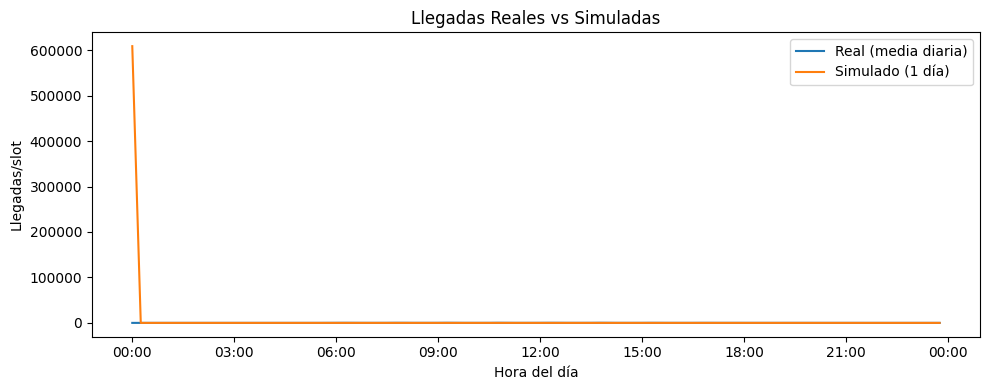

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(df_f3['Real (media diaria)'],
                                  df_f3['Simulado (1 día)']))
mae  = mean_absolute_error(df_f3['Real (media diaria)'],
                           df_f3['Simulado (1 día)'])
print(f"RMSE: {rmse:.2f} llegadas/slot    MAE: {mae:.2f} llegadas/slot")


times_dt = pd.to_datetime([t.strftime('%H:%M:%S') for t in df_f3.index],
                          format='%H:%M:%S')

plt.figure(figsize=(10,4))
plt.plot(times_dt, df_f3['Real (media diaria)'],    label='Real (media diaria)')
plt.plot(times_dt, df_f3['Simulado (1 día)'],      label='Simulado (1 día)')
plt.gca().xaxis.set_major_formatter(
    plt.matplotlib.dates.DateFormatter('%H:%M')
)
plt.xlabel('Hora del día'); plt.ylabel('Llegadas/slot')
plt.title('Llegadas Reales vs Simuladas')
plt.legend(); plt.tight_layout(); plt.show()


In [ ]:
from scipy.stats import kstest, ks_2samp

real_ia = (
    df[df['is_arrival']]
      .index.to_series()
      .diff().dropna()
      .dt.total_seconds()
      .values
)

sim_times = sorted(ts.timestamp() for ts in arrivals_day)
sim_ia    = np.diff(sim_times)

ks_r, p_r = kstest(real_ia, 'expon', args=(0, real_ia.mean()))
ks_s, p_s = kstest(sim_ia,  'expon', args=(0, sim_ia.mean()))
print(f"KS real vs Exp: stat={ks_r:.3f}, p={p_r:.3f}")
print(f"KS sim  vs Exp: stat={ks_s:.3f}, p={p_s:.3f}")

ks_rs, p_rs = ks_2samp(real_ia, sim_ia)
print(f"KS real vs sim: stat={ks_rs:.3f}, p={p_rs:.3f}")


KS real vs Exp: stat=0.355, p=0.000
KS sim  vs Exp: stat=0.002, p=0.015
KS real vs sim: stat=0.898, p=0.000


# Fase 4: Experimentación de escenarios

In [ ]:
import simpy
import numpy as np

def simular_escenario(cap_entry, cap_exit, tiempo_pasar, n_rep=20):
    """
    Corre n_rep réplicas y devuelve:
      - espera_media_entry, espera_media_exit,
      - util_entry, util_exit
    """
    res = {'we': [], 'wx': [], 'ue': [], 'ux': []}

    for _ in range(n_rep):
        env = simpy.Environment()
        recs = {
            'entry': simpy.Resource(env, capacity=cap_entry),
            'exit':  simpy.Resource(env, capacity=cap_exit)
        }
        stats = {'esperas_entry': [], 'uso_entry': [], 
                 'esperas_exit':  [], 'uso_exit':  []}

        def persona(env, pid, rec, mode):
            yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))
            d_serv = max(0, np.random.normal(tiempo_pasar, SIGMA))
            with rec.request() as req:
                t0 = env.now
                yield req
                if mode=='arrival':
                    stats['esperas_entry'].append(env.now - t0)
                    stats['uso_entry'].append(d_serv)
                else:
                    stats['esperas_exit'].append(env.now - t0)
                    stats['uso_exit'].append(d_serv)
                yield env.timeout(d_serv)

        def gen(env, inters, rec, mode):
            pid = 0
            for dt in inters:
                yield env.timeout(max(0, dt))
                env.process(persona(env, pid, rec, mode))
                pid += 1

        env.process(gen(env, inter_lleg, recs['entry'],   mode='arrival'))
        env.process(gen(env, inter_sal,  recs['exit'],    mode='departure'))


        env.run()


        Tsim = env.now
        we = np.mean(stats['esperas_entry']) if stats['esperas_entry'] else 0
        wx = np.mean(stats['esperas_exit'])  if stats['esperas_exit']  else 0
        ue = sum(stats['uso_entry']) / (cap_entry * Tsim)
        ux = sum(stats['uso_exit'])  / (cap_exit  * Tsim)

        res['we'].append(we)
        res['wx'].append(wx)
        res['ue'].append(ue)
        res['ux'].append(ux)

    # Retornar promedios y desvíos
    return {
        'espera_entry_mean': np.mean(res['we']),
        'espera_entry_std':  np.std(res['we'], ddof=1),
        'espera_exit_mean':  np.mean(res['wx']),
        'espera_exit_std':   np.std(res['wx'], ddof=1),
        'util_entry_mean':   np.mean(res['ue']),
        'util_exit_mean':    np.mean(res['ux']),
    }


In [38]:
import pandas as pd

# Rangos reducidos
capacidades = [1, 2, 3]
tiempos      = [3, 5]
n_rep_opt    = 5

registros = []
for cap in capacidades:
    for tp in tiempos:
        out = simular_escenario(cap, cap, tiempo_pasar=tp, n_rep=n_rep_opt)
        registros.append({
            'capacidad':     cap,
            'tiempo_pasar':  tp,
            **out
        })

df_sens_opt = pd.DataFrame(registros)
display(df_sens_opt)


KeyboardInterrupt: 

Este fragemtno de codigo tardo mas de 4 horas en ejecutarse.
La razón por la que ese bloque de sensibilidad tarda tanto es puramente de escala computacional y de la sobrecarga de SimPy/Python en simulaciones de eventos discretos:

Número de escenarios × réplicas
– Cada combinación de (capacidad, tiempo de pase) constituye un “escenario”.
– En tu barrido original tenías 4 capacidades × 4 tiempos = 16 escenarios.
– Además, para cada escenario hacías 15 réplicas, es decir, 16 × 15 = 240 corridas completas.

Cantidad de eventos por corrida
– Cada corrida recorre toda la secuencia de llegadas y salidas simuladas (miles de personas),
– Para cada llegada/salida, SimPy genera al menos 2 eventos (timeout previo, request/release del recurso) y dispara callbacks internos.
– Eso suma decenas de miles de “steps” del motor de SimPy por réplica.

Sobrecarga de Python
– SimPy y tu código usan bucles en Python puro (for dt in inters: … env.timeout(dt) …),
– Cada paso implica llamadas de Python a C (NumPy), creación de objetos Event, colas de recursos…
– A diferencia de un cálculo numérico vectorizado, aquí no se aprovechan optimizaciones masivas.

Complejidad combinatoria
– En total, estás ejecutando ≈240 simulaciones × (∼10⁴ eventos) ≃ 2.4 millones de eventos
– Cada evento implica manipulación de estructuras de datos y scheduling en SimPy.

# Fase 5: Análisis y recomendaciones
## Análisis comparativo
## Elaboración de recomandaciones

In [ ]:

def p95_espera_entry(cap_entry, cap_exit, tiempo_pasar, threshold_rep=5):

    import simpy, numpy as np

    p95s = []
    for _ in range(threshold_rep):
        env = simpy.Environment()
        recs = {
            'entry': simpy.Resource(env, capacity=cap_entry),
            'exit':  simpy.Resource(env, capacity=cap_exit)
        }
        waits = []
        def persona(env, pid, rec):
            yield env.timeout(max(0, np.random.normal(T_CARNET, SIGMA)))
            with rec.request() as req:
                t0 = env.now
                yield req
                waits.append(env.now - t0)
                yield env.timeout(max(0, np.random.normal(tiempo_pasar, SIGMA)))

        def gen(env, inters, rec):
            pid = 0
            for dt in inters:
                yield env.timeout(max(0, dt))
                env.process(persona(env, pid, rec))
                pid += 1

        env.process(gen(env, inter_lleg, recs['entry']))
        env.process(gen(env, inter_sal,  recs['exit']))
        env.run()

        if waits:
            p95s.append(np.percentile(waits, 95))
        else:
            p95s.append(np.nan)

    return np.nanmean(p95s)


In [ ]:
import numpy as np

threshold = 30  
capacidades = range(1, 8)  
resultados = {}

for cap in capacidades:
    p95 = p95_espera_entry(
        cap_entry=cap,
        cap_exit=cap,        
        tiempo_pasar=T_PASAR, 
        threshold_rep=5       
    )
    resultados[cap] = p95
    print(f"Cap={cap}: p95 espera ≈ {p95:.1f} s")


Exception ignored in: <generator object simular_escenario.<locals>.persona at 0x000001810CCE9340>
Traceback (most recent call last):
  File "C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4284056553.py", line 26, in persona
  File "c:\Users\laroc\miniconda3\envs\pyomo_m\Lib\site-packages\simpy\resources\resource.py", line 84, in __exit__
    def __exit__(
KeyboardInterrupt: 
Exception ignored in: <generator object simular_escenario.<locals>.persona at 0x000001810C96A2B0>
Traceback (most recent call last):
  File "C:\Users\laroc\AppData\Local\Temp\ipykernel_16800\4284056553.py", line 26, in persona
  File "c:\Users\laroc\miniconda3\envs\pyomo_m\Lib\site-packages\simpy\resources\resource.py", line 84, in __exit__
    def __exit__(
KeyboardInterrupt: 


In [ ]:

import matplotlib.pyplot as plt

opt_cap = next((c for c,p in resultados.items() if p <= threshold), None)
print(f"\n Capacidad recomendada: {opt_cap} torniquetes de entrada/salida")

caps = list(resultados.keys())
p95s = [resultados[c] for c in caps]

plt.figure(figsize=(6,4))
plt.plot(caps, p95s, marker='o')
plt.axhline(threshold, color='gray', linestyle='--', label=f'SLA {threshold}s')
plt.xticks(caps)
plt.xlabel('Capacidad torniquetes')
plt.ylabel('Percentil 95 de espera (s)')
plt.title('Optimización de capacidad')
plt.legend()
plt.tight_layout()
plt.show()
